In [124]:
""" 

DESCRIPTION

1. Produce annual July-July accumulation data from MERRA2.

"""

# Import modules
import xarray as xr
import netCDF4
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

# Define path
path = '/Users/jryan4/Dropbox (University of Oregon)/research/snowfall/data/'

In [120]:
# Define MERRA files
merra_snow_files = sorted(glob.glob(path + 'merra_snowfall_monthly/*.nc'))

# Define years
years = np.arange(1981, 2022)

In [25]:
# Get July index
july_idx = []
for i in range(len(merra_snow_files)):
    if os.path.basename(merra_snow_files[i])[31:33] == '07':
        july_idx.append(i)

In [118]:
avg_snow_years = np.zeros((51,99))
avg_evap_years = np.zeros((51,99))
for idx in range(len(july_idx) - 1):
    avg_snow = np.zeros((51,99))
    avg_evap = np.zeros((51,99))
    for month in np.arange(0,12):
        # Read files
        merra = xr.open_dataset(merra_snow_files[july_idx[idx] + month])
        
        # Stack
        avg_snow = np.dstack((avg_snow, merra['PRECSN'][0,:,:].values))
        avg_evap = np.dstack((avg_evap, merra['EVAP'][0,:,:].values))
        
        # Remove first layer
        avg_snow = avg_snow[:,:,1:]
        avg_evap = avg_evap[:,:,1:]
        
    # Produce annual average
    avg_snow_years = np.dstack((avg_snow_years, np.nanmean(avg_snow, axis=2)))
    avg_evap_years = np.dstack((avg_evap_years, np.nanmean(avg_evap, axis=2)))

# Remove first layer
avg_snow_years = avg_snow_years[:,:,1:]
avg_evap_years = avg_evap_years[:,:,1:]

# Compute accumulation
avg_accum = avg_snow_years + avg_evap_years

# Convert to meters per year
avg_accum_m = avg_accum * 86400 * 365 / 1000

In [125]:
# Save to netCDF
def save2netcdf(dest, lats, lons, data1, year):
    dataset = netCDF4.Dataset(dest + 'merra_accumulation_J-J_1980-2021.nc', 'w', format='NETCDF4_CLASSIC')
    print('Creating %s' %dest + 'merra_accumulation_J-J_1980-2021.nc')
    dataset.Title = "Annual accumulation between July and July from MERRA2 between 1980 and 2021"
    import time
    dataset.History = "Created " + time.ctime(time.time())
    dataset.Projection = "WGS 84"
    dataset.Reference = "Ryan, J. C., et al. (unpublished)"
    dataset.Contact = "jryan4@uoregon.edu"
        
    # Create new dimensions
    lat_dim = dataset.createDimension('y', data1.shape[0])
    lon_dim = dataset.createDimension('x', data1.shape[1])
    data_dim = dataset.createDimension('z', data1.shape[2])
        
    # Define variable types
    Y = dataset.createVariable('latitude', np.float64, ('y','x'))
    X = dataset.createVariable('longitude', np.float64, ('y','x'))
    
    y = dataset.createVariable('y', np.float64, ('y'))
    x = dataset.createVariable('x', np.float64, ('x'))
    z = dataset.createVariable('z', np.float64, ('z'))
        
    # Define units
    Y.units = "degrees"
    X.units = "degrees"
       
    # Create the actual 3D variable
    acc_nc = dataset.createVariable('acc', np.float64, ('y','x','z'))
    acc_nc.units = "meters per year w.e."
    
    # Write data to layers
    Y[:] = lats
    X[:] = lons
    x[:] = lons[0,:]
    y[:] = lats[:,0]
    z[:] = year
    acc_nc[:] = data1

    print('Writing data to %s' %dest + 'merra_accumulation_J-J_1980-2021.nc')
        
    # Close dataset
    dataset.close()

In [128]:
xx,yy = np.meshgrid(merra['lon'].values, merra['lat'].values)

In [135]:
save2netcdf(path, yy, xx, avg_accum_m, years)

Creating /Users/jryan4/Dropbox (University of Oregon)/research/snowfall/data/merra_accumulation_J-J_1980-2021.nc
Writing data to /Users/jryan4/Dropbox (University of Oregon)/research/snowfall/data/merra_accumulation_J-J_1980-2021.nc


In [136]:
test = xr.open_dataset('/Users/jryan4/Dropbox (University of Oregon)/research/snowfall/data/merra_accumulation_J-J_1980-2021.nc')

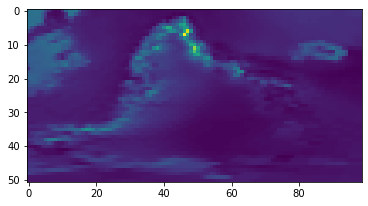

In [140]:
plt.imshow(np.nanmean(test['acc'], axis=2))